In [47]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import pyrtools as pt
import plenoptic as po

%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype  = torch.float32
torch.__version__

numpy = lambda x : x.detach().cpu().squeeze().numpy()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# A basic non-linear model

In [15]:
# steerable pyramid reminder

# SPF = po.simul.Steerable_Pyramid_Freq(image.shape, order=3, height=3, is_complex=False)
# impulse = torch.zeros_like(x)
# impulse[...,16,16] = 1
# pyr = SPF(impulse)
# pt.pyrshow(pyr, zoom=2);

class toy_model(nn.Module):
    """steerable pyramid followed by local gain control"""
    def __init__(self, cmplx=False):
        super(toy_model, self).__init__()

        if cmplx:
            self.SPF = po.simul.Steerable_Pyramid_Freq(image.shape, order=2, height=2, is_complex=True)
            self.nl = po.simul.rectangular_to_polar_dict
        else:
            self.SPF = po.simul.Steerable_Pyramid_Freq(image.shape, order=2, height=2, is_complex=False)
            self.nl = po.simul.local_gain_control
    
    def forward(self, x):
        
        pyr = self.SPF(x) 
        _, state = self.nl(pyr)

        return torch.cat([s.squeeze().view(-1) for s in state.values()]).unsqueeze(1)

In [16]:
M = toy_model()

# A few test images
on small images we can rapidly compute the Jacobain

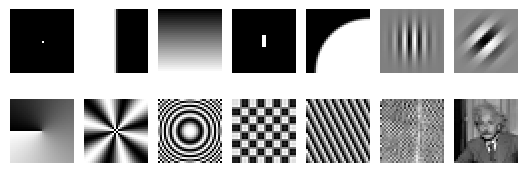

In [52]:
stimuli = po.make_basic_stimuli(32)
pt.imshow(numpy(stimuli), title=None, col_wrap=7, zoom=2);

# Input output Jacobian (aka. first order Taylor)

Exhaustive construction of the input output Jacobian evaluated at this image takes about a minute

In [54]:
# Note: making sure to define the tensors without breaking the graph
i = 12
x = torch.tensor(stimuli[i]).unsqueeze(0)
x_flat = x.flatten().unsqueeze(1).requires_grad_()

J = po.synth.autodiff.jacobian(M(x_flat.view_as(x)), x_flat)

/Users/pe/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


(3840, 1024)


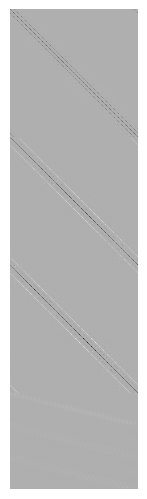

In [55]:
J = numpy(J)
print(J.shape) # out by in, tall and skinny matrix, overcomplete representation
pt.imshow(J, zoom=.125, title=None);

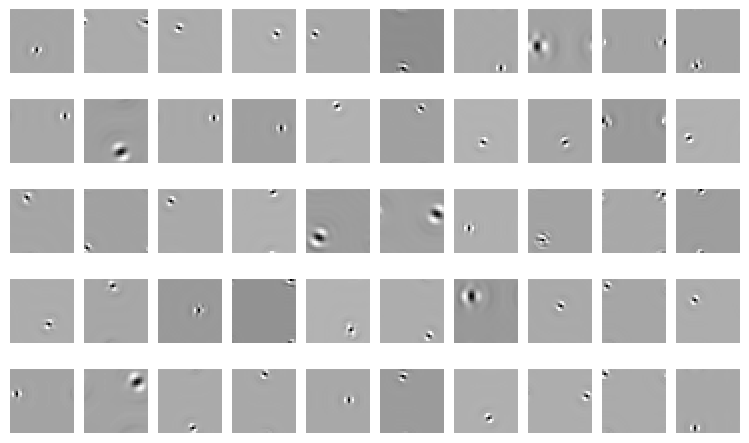

In [56]:
# visualization of some random channels
# as expected
N = 50
random_lines_J = J[np.random.choice(np.arange(len(J)), N, replace=False)]
pt.imshow(random_lines_J.reshape(N, *image.shape), vrange='indep1', col_wrap=10, title=None, zoom=2);

In [61]:
# TODO show how it adapts to the content of the image

# SVD of the Jacobian

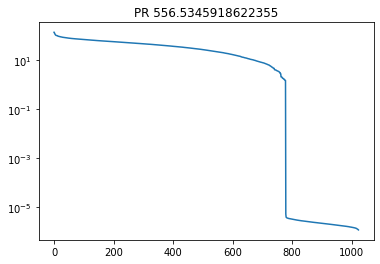

In [60]:
# computing the svd
U,s,Vh = np.linalg.svd(J)
# Note that svd returns the conjugate transpose of V,
# columns of V form a basis of the input space
# so here we need to look as rows of Vh (its real valued).

# a way to think about effective dimensionality
participation_ratio = (s.sum() ** 2 / (s ** 2).sum())

plt.plot(s)
# indicating where nullspace roughly starts
# threshold = np.where(np.log(s) < -20)[0].min()
# plt.axvline(threshold)
plt.yscale('log')
plt.title('PR '+ str(participation_ratio))
plt.show()

Looking at some of the basis vectors of the nullspace. Tndeed our model disgards high frequencies.

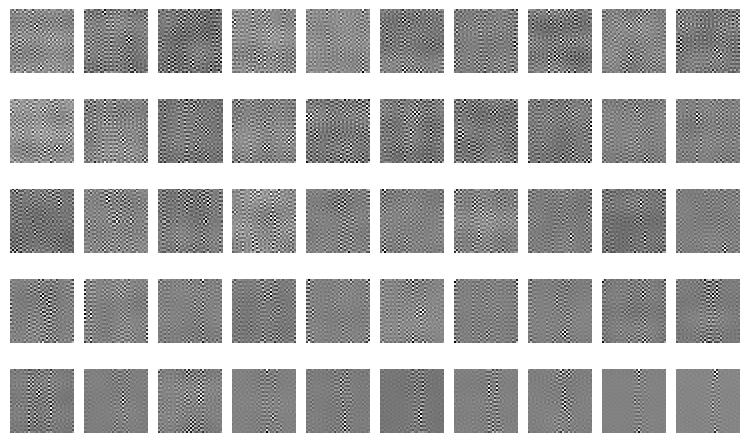

In [58]:
pt.imshow(Vh[-50:].reshape(N, *image.shape),
          title=None, col_wrap=10, zoom=2);

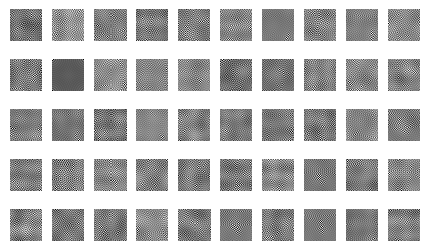

In [37]:
# some other random hardly visible distortions
random_nullspace = Vh[np.random.choice(np.arange(threshold, len(Vh), 1), N, replace=False)]
pt.imshow(random_nullspace.reshape(N, *image.shape),
          title=None, col_wrap=10, zoom=1);

the actual dominant evecs, aka. the visible eigendistortions

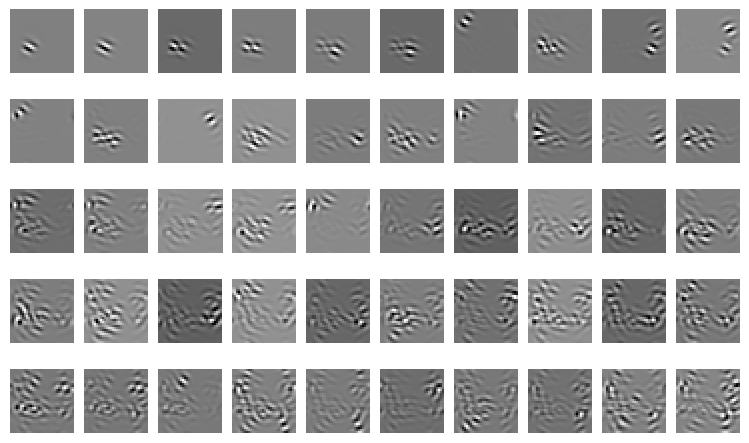

In [59]:
pt.imshow(Vh[:N].reshape(N, *image.shape),
          title=None, col_wrap=10, zoom=2);

looking at some basis vectors of the column space (reweighted for fun)

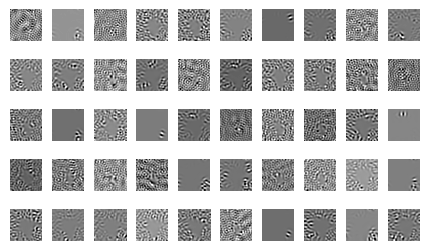

In [36]:
prob = (s[:threshold])
prob /= prob.sum()
random_colspace = Vh[np.random.choice(np.arange(0, threshold, 1), N, replace=False, p=prob)]

pt.imshow(random_colspace.reshape(N, *image.shape),
          title=None, col_wrap=10, zoom=1);